In [ ]:
# hide
# skip
! [ -e /content ] && pip install -Uqq model_inspector
# For colab. Restart the runtime after running this cell!

In [ ]:
# default_exp inspect

In [ ]:
# export
from functools import partial, update_wrapper
from typing import Iterable, Optional, Sequence, Union
import warnings

from IPython.display import HTML
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import ClassifierMixin, clone, RegressorMixin
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.validation import check_is_fitted
import waterfall_chart

from model_inspector.explore import plot_correlation
from model_inspector.tune import calculate_metrics_by_thresh

# inspect

> Inspect models.

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
# export
# Meant to be colorblind-friendly
COLORS = {"blue": "#377eb8", "orange": "#ff7f00", "green": "#4daf4a", "pink": "#f781bf"}

In [ ]:
# export
def Inspector(model, X: pd.DataFrame, y: pd.Series):
    """Model inspector

    Parameters:
    - `model`: Fitted sklearn model
    - `X`: Feature matrix with same shape and column meanings as
    features `model` was trained on
    - `y`: Target series with same length as `X` and same meaning as
    target `model` was trained on
    """
    if hasattr(model, "coef_") and hasattr(model, "intercept_"):
        if isinstance(model, RegressorMixin):
            result = _LinRegInspector(model, X, y)
        elif isinstance(model, ClassifierMixin):
            result = _LogRegInspector(model, X, y)
    else:
        result = _Inspector(model, X, y)
    return result

In [ ]:
# export
class _Inspector:
    def __init__(self, model, X, y):
        check_is_fitted(model)

        self.model, self.X, self.y = model, X, y

        self.plot_correlation = partial(
            plot_correlation, pd.concat((self.X, self.y), axis="columns")
        )
        update_wrapper(self.plot_correlation, plot_correlation)

        is_binary = (
            isinstance(self.model, ClassifierMixin) and len(self.y.unique()) == 2
        )
        if is_binary:
            self.calculate_metrics_by_thresh = partial(
                calculate_metrics_by_thresh, self.y, model.predict_proba(self.X)
            )
            update_wrapper(
                self.calculate_metrics_by_thresh, calculate_metrics_by_thresh
            )

        if len(X.columns) == 1:
            if is_binary:
                self.plot = partial(_plot1_bin, self)
                update_wrapper(self.plot, _plot1_bin)
            else:
                self.plot = partial(_plot1, self)
                update_wrapper(self.plot, _plot1)
        if len(X.columns) == 2:
            if isinstance(self.model, ClassifierMixin):
                self.plot = partial(_plot2_clas, self)
                update_wrapper(self.plot, _plot2_clas)
                if is_binary:
                    self.plot3d = partial(_plot3d_bin, self)
                    update_wrapper(self.plot3d, _plot3d_bin)
                else:
                    self.plot3d = partial(_plot3d_multiclass, self)
                    update_wrapper(self.plot3d, _plot3d_multiclass)
            else:
                self.plot = partial(_plot2_regression, self)
                update_wrapper(self.plot, _plot2_regression)
                self.plot3d = partial(_plot3d_regression, self)
                update_wrapper(self.plot3d, _plot3d_regression)

In [ ]:
# export
class _LinearInspector(_Inspector):
    def __init__(self, model, X, y):
        super().__init__(model, X, y)
        if isinstance(self.model, ClassifierMixin) and len(self.y.unique()) == 2:
            self.plot_waterfall = partial(_plot_waterfall_bin, self)
            update_wrapper(self.plot_waterfall, _plot_waterfall_bin)

    def show_equation(*args, **kwargs):
        raise NotImplementedError()

    def plot_coefs_vs_hparam(*args, **kwargs):
        raise NotImplementedError()

In [ ]:
# export
class _LinRegInspector(_LinearInspector):
    """Linear regression model inspector"""

    def plot_coefs_vs_hparam(self, hparam: str, vals: Sequence[float]):
        """Plot coefficient values against a hyperparameter

        Parameters:
        - `hparam`: Name of hyperparameter; must be an attribute of
        `self.model`
        - `vals`: Values of that hyperparameter to use
        """
        current_val = getattr(self.model, hparam)
        model = clone(self.model)
        setattr(model, hparam, vals[-1])
        model.fit(self.X, self.y)
        column_order = model.coef_.argsort()[::-1]
        X = self.X.iloc[:, column_order]

        coefs = []
        for val in vals:
            setattr(model, hparam, val)
            coefs.append(model.fit(X, self.y).coef_)

        fig, ax = plt.subplots()
        ax.plot(vals, coefs)
        ax.axvline(current_val, c="k", label="current value")
        ax.set(xlabel=hparam, ylabel="coefficient value")
        ax.legend(X.columns, bbox_to_anchor=(1.05, 1.0), loc="upper left")
        return ax

    def plot_waterfall(
        self,
        item: Union[pd.Series, np.array],
        bar_num_formatter: str = ".1f",
        tick_num_formatter: str = ".2f",
        waterfall_kwargs: Optional[dict] = None,
    ):
        """Make a waterfall chart showing how each feature contributes
        to the prediction for the input item.

        Parameters:
        - `item`: Input item, with the same shape and value meanings as
        a single row from `self.X`
        - `bar_num_formatter`: Bar label format specifier
        - `tick_num_formatter`: Tick label format specifier
        - `waterfall_kwargs`: kwargs to pass to `waterfall_chart.plot`
        """
        if waterfall_kwargs is None:
            waterfall_kwargs = {
                "sorted_value": True,
                "threshold": 0.01,
                "blue_color": COLORS["blue"],
                "green_color": COLORS["green"],
                "red_color": COLORS["orange"],
            }
        index = ["int"] + [
            f"{name}: {val:{tick_num_formatter}}"
            for name, val in zip(self.X.columns, item)
        ]
        vals = [self.model.intercept_] + list(self.model.coef_ * item)
        waterfall_chart.plot(
            index=index,
            data=vals,
            x_lab="Feature name and value",
            y_lab="Contribution to prediction",
            formatting=f"{{:,{bar_num_formatter}}}",
            net_label=self.y.name,
            **waterfall_kwargs,
        )
        return plt.gca()

    def show_equation(
        self,
        intercept_formatter: str = ".2f",
        coef_formatter: str = ".2f",
    ):
        """Show linear model equation

        Parameters:
        - `intercept_formatter`: Intercept format specifier
        - `coef_formatter`: Intercept format specifier
        """
        return HTML(
            _generate_linear_model_html(
                intercept=self.model.intercept_,
                coefs=self.model.coef_,
                feature_names=self.X.columns,
                target_name=self.y.name,
                intercept_formatter=intercept_formatter,
                coef_formatter=coef_formatter,
            )
        )

In [ ]:
# export
class _LogRegInspector(_LinearInspector):
    """Logistic regression model inspector"""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        is_binary = len(self.y.unique()) == 2
        if is_binary:
            self.show_equation = partial(_show_equation_bin, self)
            update_wrapper(self.show_equation, _show_equation_bin)
        else:
            self.show_equation = partial(_show_equation_multiclass, self)
            update_wrapper(self.show_equation, _show_equation_multiclass)

    def plot_coefs_vs_hparam(self, hparam: str, vals: Sequence[float]) -> np.array:
        """Plot coefficient values against a hyperparameter

        Parameters:
        - `hparam`: Name of hyperparameter; must be an attribute of
        `self.model`
        - `vals`: Values of that hyperparameter to use
        """
        current_val = getattr(self.model, hparam)
        model = clone(self.model)
        setattr(model, hparam, vals[-1])
        column_order = model.fit(self.X, self.y).coef_[0].argsort()[::-1]
        X = self.X.iloc[:, column_order]

        coef_arrays = []
        for val in vals:
            setattr(model, hparam, val)
            coef_arrays.append(model.fit(self.X, self.y).coef_)

        num_target_vals = len(set(self.y))
        if num_target_vals == 2:
            fig, ax = plt.subplots()
            ax.plot(vals, [coefs[0] for coefs in coef_arrays])
            axes = np.array(ax)[None]
        else:
            fig, axes = plt.subplots(
                num_target_vals, 1, sharex=True, sharey=True, constrained_layout=True
            )
            for target_val_num in range(num_target_vals):
                axes[target_val_num].plot(
                    vals, [coefs[target_val_num] for coefs in coef_arrays]
                )
                axes[target_val_num].set_title(
                    f"y={sorted(set(self.y))[target_val_num]}"
                )
        axes[0].set(xlabel=hparam, ylabel="Coefficient Value")
        for ax in axes:
            ax.axvline(current_val, c="k", label="current value")
        axes[0].legend(X.columns, bbox_to_anchor=(1.05, 1.0), loc="upper left")
        return axes

In [ ]:
# export
def _show_equation_multiclass(
    inspector,
    intercept_formatter: str = ".2f",
    coef_formatter: str = ".2f",
):
    """Show multiclass logistic model equation

    Parameters:
    - `intercept_formatter`: Intercept format specifier
    - `coef_formatter`: Intercept format specifier
    """
    model_string = ""
    for target_name, coefs, intercept in zip(
        self.y.unique(), self.model.coef_, self.model.intercept_
    ):
        model_string += f"""
                <p>
                    {_generate_linear_model_html(
                            intercept=intercept,
                            coefs=coefs,
                            feature_names=self.X.columns,
                            target_name=f"log-odds({self.y.name} = {target_name})",
                            intercept_formatter=intercept_formatter,
                            coef_formatter=coef_formatter,
                        )
                    }
                </p>
            """
    return HTML(model_string)

In [ ]:
# export
def _show_equation_bin(
    inspector,
    intercept_formatter: str = ".2f",
    coef_formatter: str = ".2f",
):
    """Show binary logistic model equation

    Parameters:
    - `intercept_formatter`: Intercept format specifier
    - `coef_formatter`: Intercept format specifier
    """
    return HTML(
        _generate_linear_model_html(
            intercept=inspector.model.intercept_[0],
            coefs=inspector.model.coef_[0],
            feature_names=inspector.X.columns,
            target_name=f"log-odds({inspector.y.name})",
            intercept_formatter=intercept_formatter,
            coef_formatter=coef_formatter,
        )
    )

In [ ]:
# export
def _plot1(
    inspector: Inspector,
    plot_data: bool = True,
    line_kwargs: Optional[dict] = None,
    scatter_kwargs: Optional[dict] = None,
    ax: Optional[Axes] = None,
) -> Axes:
    """Plot predictions from a regression or multiclass model with a
    single input as a line

    Parameters:
    - `inspector`: `Inspector` object
    - `plot_data`: Make a scatter plot of the data
    - `line_kwargs`: kwargs to pass to `ax.plot` for plotting
    predictions
    - `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
    - `ax`: Matplotlib `Axes` object. Plot will be added to this object
    if provided; otherwise a new `Axes` object will be generated.
    """

    def _plot_preds(ax):
        X_sorted = inspector.X.sort_values(inspector.X.columns[0])
        ax.plot(
            X_sorted.iloc[:, 0],
            inspector.model.predict(X_sorted),
            label="predictions",
            **line_kwargs,
        )
        return ax

    if line_kwargs is None:
        line_kwargs = {}
    if scatter_kwargs is None:
        scatter_kwargs = {"c": "k", "alpha": 0.4}
    if ax is None:
        _, ax = plt.subplots()
    if plot_data:
        ax.scatter(inspector.X.iloc[:, 0], inspector.y, **scatter_kwargs)
    ax = _plot_preds(ax)
    ax.set(xlabel=inspector.X.columns[0], ylabel=inspector.y.name)
    ax.legend()
    return ax

In [ ]:
# export
def _plot1_bin(
    inspector: Inspector,
    thresh: Optional[float] = 0.5,
    plot_data: bool = True,
    prob_line_kwargs: Optional[dict] = None,
    thresh_line_kwargs: Optional[dict] = None,
    scatter_kwargs: Optional[dict] = None,
    ax: Optional[Axes] = None,
) -> Axes:
    """Plot predictions from a binary classification model that provides
    probabilities and has a single input

    Parameters:
    - `inspector`: `Inspector` object
    - `thresh`: Threshold probability
    - `plot_data`: Make a scatter plot of the data
    - `prob_line_kwargs`: kwargs to pass to `ax.plot` for plotting
    model probabilities
    - `thresh_line_kwargs`: kwargs to pass to `ax.plot` for plotting
    threshold
    - `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
    - `ax`: Matplotlib `Axes` object. Plot will be added to this object
    if provided; otherwise a new `Axes` object will be generated.
    """

    def _plot_probs(ax):
        num_points = 100
        X = np.linspace(inspector.X.min(), inspector.X.max(), num_points)
        ax.plot(
            X,
            inspector.model.predict_proba(X)[:, 1],
            label="probability",
            **prob_line_kwargs,
        )
        return ax

    if ax is None:
        _, ax = plt.subplots()
    if prob_line_kwargs is None:
        prob_line_kwargs = {}
    if thresh_line_kwargs is None:
        thresh_line_kwargs = {}
    if scatter_kwargs is None:
        scatter_kwargs = {"c": "k", "alpha": 0.4}

    if plot_data:
        ax.scatter(inspector.X.iloc[:, 0], inspector.y, **scatter_kwargs)
    ax = _plot_probs(ax)
    if thresh:
        ax.plot(
            inspector.X.iloc[:, 0],
            thresh * np.ones(inspector.X.shape),
            **thresh_line_kwargs,
        )
    ax.set(xlabel=inspector.X.columns[0], ylabel=inspector.y.name)
    ax.legend()
    return ax

In [ ]:
# export
def _plot2_regression(
    inspector: Inspector,
    plot_data: bool = True,
    heatmap_kwargs: Optional[dict] = None,
    scatter_kwargs: Optional[dict] = None,
    tick_formatter: Optional[str] = ".2f",
    ax=None,
):
    """Plot predictions from a model with two inputs as a heatmap.

    Parameters:
    - `inspector`: `Inspector` object
    - `plot_data`: Make a scatter plot of the data
    - `heatmap_kwargs`: kwargs to pass to `sns.heatmap` for plotting
    predictions
    - `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
    - `tick_formatter`: Tick label format specifier
    - `ax`: Matplotlib `Axes` object. Plot will be added to this object
    if provided; otherwise a new `Axes` object will be generated.
    """

    def _plot_preds(ax, **heatmap_kwargs):
        x_grid = np.linspace(
            inspector.X.iloc[:, 0].min(), inspector.X.iloc[:, 0].max(), 100
        )
        y_grid = np.linspace(
            inspector.X.iloc[:, 1].max(), inspector.X.iloc[:, 1].min(), 100
        )

        preds = inspector.model.predict(
            np.transpose([np.tile(x_grid, len(y_grid)), np.repeat(y_grid, len(x_grid))])
        ).reshape(len(y_grid), len(x_grid))
        preds = pd.DataFrame(preds, columns=x_grid, index=y_grid)
        return sns.heatmap(
            preds,
            vmin=inspector.y.min(),
            vmax=inspector.y.max(),
            ax=ax,
            **heatmap_kwargs,
        )

    if ax is None:
        _, ax = plt.subplots()
    if heatmap_kwargs is None:
        heatmap_kwargs = {"cmap": "viridis"}
    if scatter_kwargs is None:
        scatter_kwargs = {"cmap": "viridis", "edgecolor": "k", "zorder": 999}

    if plot_data:
        ax = _plot_data_2d(X=inspector.X, y=inspector.y, ax=ax, **scatter_kwargs)
    ax = _plot_preds(ax=ax, **heatmap_kwargs)
    if tick_formatter is not None:
        _format_ticks(ax=ax, formatter=tick_formatter)
    ax.set(
        xlabel=inspector.X.columns[0],
        ylabel=inspector.X.columns[1],
        title=inspector.y.name,
    )
    return ax

In [ ]:
# export
def _plot2_clas(
    inspector: Inspector,
    plot_data: bool = True,
    heatmap_kwargs: Optional[dict] = None,
    scatter_kwargs: Optional[dict] = None,
    tick_formatter: Optional[str] = ".2f",
    ax=None,
):
    """Plot data and predictions for classification model with two features

    Parameters:
    - `inspector`: `Inspector` object
    - `plot_data`: Make a scatter plot of the data
    - `heatmap_kwargs`: kwargs to pass to `sns.heatmap` for plotting
    predictions
    - `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
    - `tick_formatter`: Tick label format specifier
    - `ax`: Matplotlib `Axes` object. Plot will be added to this object
    if provided; otherwise a new `Axes` object will be generated.
    """

    def _plot_preds(y_vals, label_to_num, ax, **scatter_kwargs):
        num_points = 100
        x_grid = np.linspace(
            inspector.X.iloc[:, 0].min(), inspector.X.iloc[:, 0].max(), num_points
        )
        y_grid = np.linspace(
            inspector.X.iloc[:, 1].max(), inspector.X.iloc[:, 1].min(), num_points
        )

        preds = inspector.model.predict(
            np.transpose([np.tile(x_grid, len(y_grid)), np.repeat(y_grid, len(x_grid))])
        ).reshape(len(y_grid), len(x_grid))
        preds = pd.DataFrame(preds, columns=x_grid, index=y_grid)
        for col in preds:
            preds.loc[:, col] = preds.loc[:, col].map(label_to_num)
        ax = sns.heatmap(preds.astype(int), **heatmap_kwargs)
        return ax

    def _set_colorbar(y_vals, ax):
        colorbar = ax.collections[0].colorbar
        r = colorbar.vmax - colorbar.vmin
        colorbar.set_ticks(
            [colorbar.vmin + r / len(y_vals) * (0.5 + i) for i in range(len(y_vals))]
        )
        colorbar.set_ticklabels(y_vals)
        return colorbar

    def _wash_out(ax):
        rectangle = plt.Rectangle((0, 0), 100, 100, fc="w", alpha=0.5)
        ax.add_patch(rectangle)
        return ax

    if ax is None:
        _, ax = plt.subplots()
    if heatmap_kwargs is None:
        heatmap_kwargs = {}
    if scatter_kwargs is None:
        scatter_kwargs = {"edgecolor": "k", "zorder": 999}

    y_vals = inspector.y.unique()
    label_to_num = {label: num for label, num in zip(y_vals, range(len(y_vals)))}
    if heatmap_kwargs.get("cmap") is None:
        heatmap_kwargs["cmap"] = sns.color_palette(None, len(y_vals))

    ax = _plot_preds(y_vals, label_to_num, ax=ax, **heatmap_kwargs)
    ax = _wash_out(ax)
    colorbar = _set_colorbar(y_vals=y_vals, ax=ax)

    if plot_data:
        if scatter_kwargs.get("cmap") is None:
            scatter_kwargs["cmap"] = colorbar.cmap
        ax = _plot_data_2d(
            X=inspector.X, y=inspector.y.map(label_to_num), ax=ax, **scatter_kwargs
        )
    _format_ticks(ax=ax, formatter=tick_formatter)
    return ax

In [ ]:
# export
def _plot_data_2d(X, y, ax, **scatter_kwargs):
    X_normalized = MinMaxScaler().fit_transform(X) * 99
    ax.scatter(
        X_normalized[:, 0] + 0.5,
        X_normalized[:, 1].max() - X_normalized[:, 1] + 0.5,
        c=y,
        **scatter_kwargs,
    )
    ax.set(xlabel=X.columns[0], ylabel=X.columns[1])
    return ax

In [ ]:
# export
def _format_ticks(ax, formatter):
    labels = [item.get_text() for item in ax.get_xticklabels()]
    ax.set_xticklabels([f"{float(label):{formatter}}" for label in labels])

    labels = [item.get_text() for item in ax.get_yticklabels()]
    ax.set_yticklabels([f"{float(label):{formatter}}" for label in labels])

In [ ]:
# export
def _plot3d_regression(
    inspector: Inspector,
    plot_data: bool = True,
    surf_kwargs: Optional[dict] = None,
    scatter_kwargs: Optional[dict] = None,
    ax=None,
):
    """Plot predictions from a model with two inputs as a surface.

    Best viewed with a tool such as https://github.com/matplotlib/ipympl
    that supports rotating the output

    Parameters:
    - `inspector`: `Inspector` object
    - `plot_data`: Make a scatter plot of the data
    - `surf_kwargs`: kwargs to pass to `ax.plot_surface` for plotting
    predictions
    - `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
    - `ax`: Matplotlib `Axes` object. Plot will be added to this object
    if provided; otherwise a new `Axes` object will be generated.
    """

    def _plot_preds(ax):

        x0_grid, x1_grid = _create_2d_grid(inspector.X)
        ax.plot_surface(
            x0_grid,
            x1_grid,
            _get_2d_grid_preds(inspector.model, x0_grid, x1_grid),
            rstride=1,
            cstride=1,
            vmin=inspector.y.min(),
            vmax=inspector.y.max(),
            **surf_kwargs,
        )
        return ax

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
    if surf_kwargs is None:
        surf_kwargs = {"alpha": 0.4, "cmap": "viridis"}
    if scatter_kwargs is None:
        scatter_kwargs = {"cmap": "viridis"}
    if plot_data:
        ax.scatter(
            inspector.X.iloc[:, 0],
            inspector.X.iloc[:, 1],
            inspector.y,
            c=inspector.y,
            **scatter_kwargs,
        )
    ax = _plot_preds(ax)
    ax.set(
        xlabel=inspector.X.columns[0],
        ylabel=inspector.X.columns[1],
        zlabel=inspector.y.name,
    )
    return ax

In [ ]:
# export
def _plot3d_multiclass(
    inspector: Inspector,
    plot_data: bool = True,
    surf_kwargs: Optional[dict] = None,
    scatter_kwargs: Optional[dict] = None,
    ax=None,
):
    """Plot predictions from a model with two inputs as a surface.

    Best viewed with a tool such as https://github.com/matplotlib/ipympl
    that supports rotating the output

    Parameters:
    - `inspector`: `Inspector` object
    - `plot_data`: Make a scatter plot of the data
    - `surf_kwargs`: kwargs to pass to `ax.plot_surface` for plotting
    predictions
    - `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
    - `ax`: Matplotlib `Axes` object. Plot will be added to this object
    if provided; otherwise a new `Axes` object will be generated.
    """
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
    if surf_kwargs is None:
        surf_kwargs = {"alpha": 0.4, "cmap": "viridis"}
    if scatter_kwargs is None:
        scatter_kwargs = {}
    y_vals = inspector.y.unique()
    label_to_num = {label: num for label, num in zip(y_vals, range(len(y_vals)))}
    y_int = inspector.y.map(label_to_num)

    y_pred_int = pd.Series(inspector.model.predict(inspector.X)).map(label_to_num)
    x0_grid, x1_grid = _create_2d_grid(inspector.X, num_points=20)
    grid_preds = pd.DataFrame(
        _get_2d_grid_preds(inspector.model, x0_grid, x1_grid)
    ).applymap(lambda x: label_to_num[x])

    for val in y_int.unique():
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            ax.plot_surface(
                x0_grid,
                x1_grid,
                grid_preds[grid_preds == val],
                rstride=1,
                cstride=1,
                alpha=0.3,
            )
        if plot_data:
            ax.scatter(
                inspector.X.iloc[:, 0].loc[y_int == val],
                inspector.X.iloc[:, 1].loc[y_int == val],
                y_pred_int.loc[y_int == val],
                **scatter_kwargs,
            )

    return ax

In [ ]:
# export
def _plot3d_bin(
    inspector: Inspector,
    thresh=0.5,
    plot_prob: bool = True,
    plot_thresh: bool = True,
    plot_data: bool = True,
    prob_surf_kwargs: Optional[dict] = None,
    thresh_surf_kwargs: Optional[dict] = None,
    scatter_kwargs: Optional[dict] = None,
    ax=None,
):
    """Plot data and predictions for binary classification model with 2
    features in 3D

    Best viewed with a tool such as https://github.com/matplotlib/ipympl
    that supports rotating the output

    Parameters:
    - `inspector`: `Inspector` object
    - `thresh`: Probability threshold for counting a prediction as
    positive
    - `plot_prob`: Whether to plot the model probabilities
    - `plot_thresh`: Whether to plot a classification threshold
    - `plot_data`: Whether to plot the data
    - `prob_surf_kwargs`: kwargs to pass to the model probability
    surface
    - `thresh_surf_kwargs`: kwargs to pass to the threshold surface
    - `scatter_kwargs`: kwargs to pass to the scatter plot of the data
    - `ax`: Matplotlib `Axes` object. Plot will be added to this object
    if provided; otherwise a new `Axes` object will be generated.
    """

    def _get_grid_probs():
        return inspector.model.predict_proba(
            np.hstack((x0_grid.reshape(-1, 1), x1_grid.reshape(-1, 1)))
        )[:, 1].reshape(x0_grid.shape)

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
    if prob_surf_kwargs is None:
        prob_surf_kwargs = {"alpha": 0.4, "cmap": "viridis"}
    if thresh_surf_kwargs is None:
        thresh_surf_kwargs = {"alpha": 0.4, "color": "k"}
    if scatter_kwargs is None:
        scatter_kwargs = {}

    x0_grid, x1_grid = _create_2d_grid(inspector.X)

    if plot_prob:
        ax.plot_surface(
            x0_grid,
            x1_grid,
            _get_grid_probs(),
            rstride=1,
            cstride=1,
            **prob_surf_kwargs,
        )
    if plot_data:
        y_pred = inspector.model.predict_proba(inspector.X)[:, 1] > thresh
        ax.scatter(
            inspector.X.loc[y_pred == inspector.y].iloc[:, 0],
            inspector.X.loc[y_pred == inspector.y].iloc[:, 1],
            inspector.y.loc[y_pred == inspector.y],
            **scatter_kwargs,
            label="correct",
        )
        ax.scatter(
            inspector.X.loc[y_pred != inspector.y].iloc[:, 0],
            inspector.X.loc[y_pred != inspector.y].iloc[:, 1],
            inspector.y.loc[y_pred != inspector.y],
            **scatter_kwargs,
            label="incorrect",
        )
        ax.legend()
    if plot_thresh:
        ax.plot_surface(
            x0_grid,
            x1_grid,
            thresh * np.ones((len(x0_grid), len(x1_grid))),
            rstride=1,
            cstride=1,
            **thresh_surf_kwargs,
        )
    ax.set(
        xlabel=inspector.X.columns[0],
        ylabel=inspector.X.columns[1],
        zlabel=f"{inspector.y.name} prediction",
    )
    return ax

In [ ]:
# export
def _create_2d_grid(X, num_points=20):
    x0_grid = np.linspace(X.iloc[:, 0].min(), X.iloc[:, 0].max(), num_points)
    x1_grid = np.linspace(X.iloc[:, 1].min(), X.iloc[:, 1].max(), num_points)
    return np.meshgrid(x0_grid, x1_grid)

In [ ]:
# export
def _get_2d_grid_preds(model, x0_grid, x1_grid):
    return model.predict(
        np.hstack((x0_grid.reshape(-1, 1), x1_grid.reshape(-1, 1)))
    ).reshape(x0_grid.shape)

In [ ]:
# export
def _plot_waterfall_bin(
    interp,
    item: Union[pd.Series, np.array],
    bar_num_formatter: str = ".1f",
    tick_num_formatter: str = ".2f",
    waterfall_kwargs: Optional[dict] = None,
):
    """Make a waterfall chart showing how each feature contributes
    to the prediction for the input item for a binary classification
    model.

    Parameters:
    - `item`: Input item, with the same shape and value meanings as
    a single row from `interp.X`
    - `bar_num_formatter`: Bar label format specifier
    - `tick_num_formatter`: Tick label format specifier
    - ``waterfall_kwargs`: kwargs to pass to `waterfall_chart.plot`
    """
    if waterfall_kwargs is None:
        waterfall_kwargs = {
            "sorted_value": True,
            "threshold": 0.01,
            "blue_color": COLORS["blue"],
            "green_color": COLORS["green"],
            "red_color": COLORS["orange"],
        }

    index = ["int"] + [
        f"{name}: {val:{tick_num_formatter}}"
        for name, val in zip(interp.X.columns, item)
    ]
    vals = [interp.model.intercept_[0]] + list(interp.model.coef_[0] * item)
    waterfall_chart.plot(
        index=index,
        data=vals,
        x_lab="Feature name and value",
        y_lab="Contribution to log-odds",
        formatting=f"{{:,{bar_num_formatter}}}",
        net_label=interp.y.name,
        **waterfall_kwargs,
    )
    return plt.gca()

In [ ]:
# export
def _generate_linear_model_html(
    intercept: float,
    coefs: Sequence[float],
    feature_names: Iterable[str],
    target_name: str,
    intercept_formatter: str = ".2f",
    coef_formatter: str = ".2f",
):
    if len(coefs) != len(feature_names):
        raise ValueError("len(coefs) != len(feature_cols)")
    model_string = f"""
        <span style='color:{COLORS["pink"]}'>{target_name}</span>
        = <span style='color:{COLORS["orange"]}'>{intercept:{intercept_formatter}}</span>
    """
    for coef, feature_col in zip(coefs, feature_names):
        model_string += f"""
            <span style='color:{COLORS["green"]}'>{"+" if coef >= 0 else "-"} {abs(coef):{coef_formatter}}</span>
            * <span style='color:{COLORS["blue"]}'>{feature_col}</span>
        """
    return model_string

# Examples

To use the functionality in this module, create an `Interpreter` object for a particular fitted scikit-learn model, feature DataFrame `X`, and target Series `y`. That object will have appropriate interpretation methods for the model type and data shape.

## Universal Methods

Every `Inspector` object can run `plot_correlation` from the `model_inspector.explore` module on `pd.concat((self.X, self.y), axis="columns")`:

<h3 id="plot_correlation" class="doc_header"><code>plot_correlation</code><a href="https://github.com/gsganden/model_inspector/tree/master/model_inspector/explore.py#L14" class="source_link" style="float:right">[source]</a></h3>

> <code>plot_correlation</code>(**`df`**:`DataFrame`, **`ax`**:`Optional`\[`Axes`\]=*`None`*, **`heatmap_kwargs`**=*`None`*)

Create correlation heatmap

Parameters:
- `df`: DataFrame
- `ax`: Matplotlib `Axes` object. Plot will be added to this object
if provided; otherwise a new `Axes` object will be generated.
- `heatmap_kwargs`: kwargs to pass to `sns.heatmap`

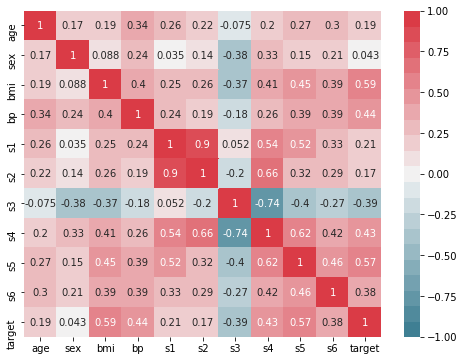

In [ ]:
import sklearn.datasets
from sklearn.ensemble import RandomForestRegressor

X_diabetes, y_diabetes = sklearn.datasets.load_diabetes(return_X_y=True, as_frame=True)

inspector = Inspector(
    RandomForestRegressor().fit(X_diabetes, y_diabetes), X_diabetes, y_diabetes
)
show_doc(inspector.plot_correlation, title_level=3)

_, ax = plt.subplots(figsize=(8, 6))
ax = inspector.plot_correlation(ax=ax)

## Binary Classifier Methods

An `Inspector` for any binary classifier can run `calculate_metrics_by_thresh` from the `model_inspector.tune` module with `y_true=self.y` and `y_prob=self.model.predict(self.X)`:

<h3 id="calculate_metrics_by_thresh" class="doc_header"><code>calculate_metrics_by_thresh</code><a href="https://github.com/gsganden/model_inspector/tree/master/model_inspector/tune.py#L15" class="source_link" style="float:right">[source]</a></h3>

> <code>calculate_metrics_by_thresh</code>(**`y_true`**:`array`, **`y_prob`**:`array`, **`prob_to_pred`**:`Union`\[`str`, `Callable`\], **`metrics`**:`Union`\[`Callable`, `Sequence`\[`Callable`\]\])

Calculate classification metrics as a function of threshold

Parameters:
- `y_true`: Ground-truth values
- `y_prob`: Probability distributions
- `prob_to_pred`: Callable that takes `y_prob` and `thresh` as positional
arguments and returns `y_pred`
- `metrics`: Callables that take `y_true`, `y_pred` as positional arguments
and return a number. Must have a `__name__` attribute.

Returns: DataFrame with one column "thresh" indicating the
thresholds used, which is 0 and the sorted set of values that occur in
`y_prob`, and an additional column for each input metric giving
the value of that metric at that threshold.

/Users/gGandenberger/.pyenv/versions/model_inspector/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


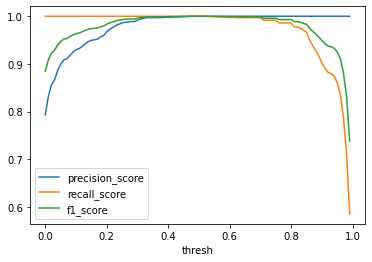

In [ ]:
import sklearn.datasets
from sklearn.ensemble import RandomForestClassifier

X_cancer, y_cancer = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)
X, y = X_cancer, y_cancer
inspector = Inspector(RandomForestClassifier().fit(X, y), X, y)
show_doc(inspector.calculate_metrics_by_thresh, title_level=3)


def predict_true_if_prob_above_thresh(y_prob, thresh):
    return np.where(y_prob[:, 1] > thresh, 1, 0)


ax = (
    inspector.calculate_metrics_by_thresh(
        prob_to_pred=predict_true_if_prob_above_thresh,
        metrics=[metrics.precision_score, metrics.recall_score, metrics.f1_score],
    )
    .iloc[:-1]
    .plot(x="thresh")
)

## Linear Model Methods

An `Inspector` for any model with an intercept and coefficients can show the model equation and plot coefficients against hyperparameters.

In [ ]:
import sklearn.datasets
from sklearn.linear_model import LinearRegression

X_diabetes, y_diabetes = sklearn.datasets.load_diabetes(return_X_y=True, as_frame=True)

inspector = Inspector(
    LinearRegression().fit(X_diabetes, y_diabetes), X_diabetes, y_diabetes
)
show_doc(inspector.show_equation, title_level=3, name=inspector.show_equation.__name__)

inspector.show_equation()

<h3 id="show_equation" class="doc_header"><code>show_equation</code><a href="__main__.py#L73" class="source_link" style="float:right">[source]</a></h3>

> <code>show_equation</code>(**`intercept_formatter`**:`str`=*`'.2f'`*, **`coef_formatter`**:`str`=*`'.2f'`*)

Show linear model equation

Parameters:
- `intercept_formatter`: Intercept format specifier
- `coef_formatter`: Intercept format specifier

In [ ]:
import sklearn.datasets
from sklearn.linear_model import LogisticRegression

X_cancer, y_cancer = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)

inspector = Inspector(
    LogisticRegression(max_iter=10_000).fit(X_cancer, y_cancer), X_cancer, y_cancer
)
show_doc(inspector.show_equation, title_level=3, name="show_equation")

inspector.show_equation()

<h3 id="show_equation" class="doc_header"><code>show_equation</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h3>

> <code>show_equation</code>(**`inspector`**, **`intercept_formatter`**:`str`=*`'.2f'`*, **`coef_formatter`**:`str`=*`'.2f'`*)

Show binary logistic model equation

Parameters:
- `intercept_formatter`: Intercept format specifier
- `coef_formatter`: Intercept format specifier

<h3 id="plot_coefs_vs_hparam" class="doc_header"><code>plot_coefs_vs_hparam</code><a href="__main__.py#L5" class="source_link" style="float:right">[source]</a></h3>

> <code>plot_coefs_vs_hparam</code>(**`hparam`**:`str`, **`vals`**:`Sequence`\[`float`\])

Plot coefficient values against a hyperparameter

Parameters:
- `hparam`: Name of hyperparameter; must be an attribute of
`self.model`
- `vals`: Values of that hyperparameter to use

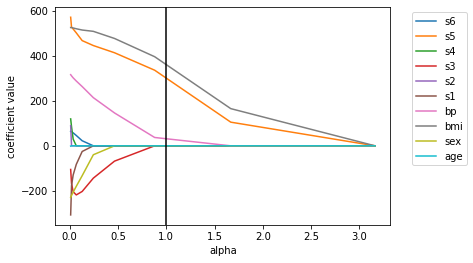

In [ ]:
import sklearn.datasets
from sklearn.linear_model import Lasso

X_diabetes, y_diabetes = sklearn.datasets.load_diabetes(return_X_y=True, as_frame=True)

inspector = Inspector(Lasso().fit(X_diabetes, y_diabetes), X_diabetes, y_diabetes)
show_doc(
    inspector.plot_coefs_vs_hparam,
    title_level=3,
    name=inspector.plot_coefs_vs_hparam.__name__,
)

ax = inspector.plot_coefs_vs_hparam("alpha", np.logspace(-2, 0.5, 10))

## Linear Regression and Binary Classification Model Methods

An `Inspector` for a regression or binary classification model with an intercept and coefficients can also generate a waterfall plot that shows how each feature contributes to a given prediction.

<h3 id="plot_waterfall" class="doc_header"><code>plot_waterfall</code><a href="__main__.py#L32" class="source_link" style="float:right">[source]</a></h3>

> <code>plot_waterfall</code>(**`item`**:`Union`\[`Series`, `array`\], **`bar_num_formatter`**:`str`=*`'.1f'`*, **`tick_num_formatter`**:`str`=*`'.2f'`*, **`waterfall_kwargs`**:`Optional`\[`dict`\]=*`None`*)

Make a waterfall chart showing how each feature contributes
to the prediction for the input item.

Parameters:
- `item`: Input item, with the same shape and value meanings as
a single row from `self.X`
- `bar_num_formatter`: Bar label format specifier
- `tick_num_formatter`: Tick label format specifier
- `waterfall_kwargs`: kwargs to pass to `waterfall_chart.plot`

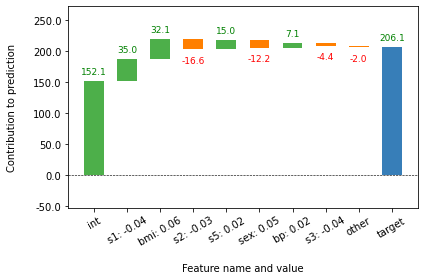

In [ ]:
import sklearn.datasets
from sklearn.linear_model import LinearRegression

X_diabetes, y_diabetes = sklearn.datasets.load_diabetes(return_X_y=True, as_frame=True)

inspector = Inspector(
    LinearRegression().fit(X_diabetes, y_diabetes), X_diabetes, y_diabetes
)
show_doc(
    inspector.plot_waterfall, title_level=3, name=inspector.plot_waterfall.__name__
)

ax = inspector.plot_waterfall(X_diabetes.iloc[0])

<h3 id="plot_waterfall" class="doc_header"><code>plot_waterfall</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h3>

> <code>plot_waterfall</code>(**`interp`**, **`item`**:`Union`\[`Series`, `array`\], **`bar_num_formatter`**:`str`=*`'.1f'`*, **`tick_num_formatter`**:`str`=*`'.2f'`*, **`waterfall_kwargs`**:`Optional`\[`dict`\]=*`None`*)

Make a waterfall chart showing how each feature contributes
to the prediction for the input item for a binary classification
model.

Parameters:
- `item`: Input item, with the same shape and value meanings as
a single row from `interp.X`
- `bar_num_formatter`: Bar label format specifier
- `tick_num_formatter`: Tick label format specifier
- ``waterfall_kwargs`: kwargs to pass to `waterfall_chart.plot`

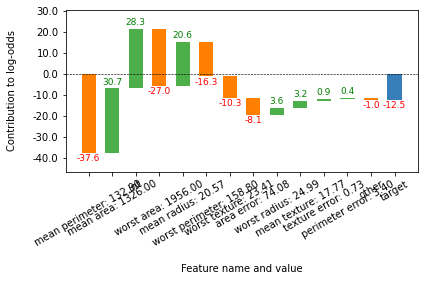

In [ ]:
import sklearn.datasets
from sklearn.linear_model import LogisticRegression

X_cancer, y_cancer = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)

inspector = Inspector(
    LogisticRegression(max_iter=10_000).fit(X_cancer, y_cancer), X_cancer, y_cancer
)
show_doc(inspector.plot_waterfall, title_level=3, name="plot_waterfall")

ax = inspector.plot_waterfall(X_cancer.iloc[1])

## One- Or Two-Feature Model Methods

An `Inspector` for any model with one or two features has `.plot()` method, and one for any model with two features also has a `.plot3d()` method.

### Binary Classification

<h4 id="plot" class="doc_header"><code>plot</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>plot</code>(**`inspector`**:[`Inspector`](/model_inspector/inspect.html#Inspector), **`thresh`**:`Optional`\[`float`\]=*`0.5`*, **`plot_data`**:`bool`=*`True`*, **`prob_line_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`thresh_line_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`scatter_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`ax`**:`Optional`\[`Axes`\]=*`None`*)

Plot predictions from a binary classification model that provides
probabilities and has a single input

Parameters:
- `inspector`: [`Inspector`](/model_inspector/inspect.html#Inspector) object
- `thresh`: Threshold probability
- `plot_data`: Make a scatter plot of the data
- `prob_line_kwargs`: kwargs to pass to `ax.plot` for plotting
model probabilities
- `thresh_line_kwargs`: kwargs to pass to `ax.plot` for plotting
threshold
- `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
- `ax`: Matplotlib `Axes` object. Plot will be added to this object
if provided; otherwise a new `Axes` object will be generated.

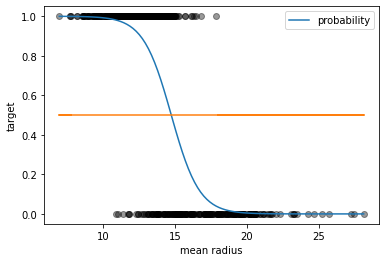

In [ ]:
import sklearn.datasets
from sklearn.linear_model import LogisticRegression

X_cancer, y_cancer = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)

inspector = Inspector(
    LogisticRegression(max_iter=10_000).fit(X_cancer.iloc[:, [0]], y_cancer),
    X_cancer.iloc[:, [0]],
    y_cancer,
)
show_doc(inspector.plot, title_level=4, name="plot")

ax = inspector.plot()

<h4 id="plot" class="doc_header"><code>plot</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>plot</code>(**`inspector`**:[`Inspector`](/model_inspector/inspect.html#Inspector), **`plot_data`**:`bool`=*`True`*, **`heatmap_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`scatter_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`tick_formatter`**:`Optional`\[`str`\]=*`'.2f'`*, **`ax`**=*`None`*)

Plot data and predictions for classification model with two features

Parameters:
- `inspector`: [`Inspector`](/model_inspector/inspect.html#Inspector) object
- `plot_data`: Make a scatter plot of the data
- `heatmap_kwargs`: kwargs to pass to `sns.heatmap` for plotting
predictions
- `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
- `tick_formatter`: Tick label format specifier
- `ax`: Matplotlib `Axes` object. Plot will be added to this object
if provided; otherwise a new `Axes` object will be generated.

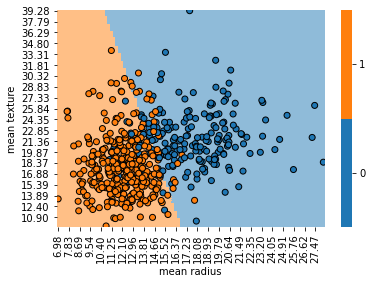

In [ ]:
import sklearn.datasets
from sklearn.linear_model import LogisticRegression

X_cancer, y_cancer = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)

inspector = Inspector(
    LogisticRegression(max_iter=10_000).fit(X_cancer.iloc[:, :2], y_cancer),
    X_cancer.iloc[:, :2],
    y_cancer,
)
show_doc(inspector.plot, title_level=4, name="plot")

ax = inspector.plot()

<h4 id="plot3d" class="doc_header"><code>plot3d</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>plot3d</code>(**`inspector`**:[`Inspector`](/model_inspector/inspect.html#Inspector), **`thresh`**=*`0.5`*, **`plot_prob`**:`bool`=*`True`*, **`plot_thresh`**:`bool`=*`True`*, **`plot_data`**:`bool`=*`True`*, **`prob_surf_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`thresh_surf_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`scatter_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`ax`**=*`None`*)

Plot data and predictions for binary classification model with 2
features in 3D

Best viewed with a tool such as https://github.com/matplotlib/ipympl
that supports rotating the output

Parameters:
- `inspector`: [`Inspector`](/model_inspector/inspect.html#Inspector) object
- `thresh`: Probability threshold for counting a prediction as
positive
- `plot_prob`: Whether to plot the model probabilities
- `plot_thresh`: Whether to plot a classification threshold
- `plot_data`: Whether to plot the data
- `prob_surf_kwargs`: kwargs to pass to the model probability
surface
- `thresh_surf_kwargs`: kwargs to pass to the threshold surface
- `scatter_kwargs`: kwargs to pass to the scatter plot of the data
- `ax`: Matplotlib `Axes` object. Plot will be added to this object
if provided; otherwise a new `Axes` object will be generated.

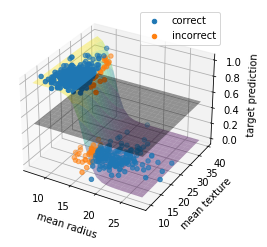

In [ ]:
import sklearn.datasets
from sklearn.linear_model import LogisticRegression

X_cancer, y_cancer = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)

inspector = Inspector(
    LogisticRegression(max_iter=10_000).fit(X_cancer.iloc[:, :2], y_cancer),
    X_cancer.iloc[:, :2],
    y_cancer,
)
show_doc(inspector.plot3d, title_level=4, name="plot3d")

ax = inspector.plot3d()

An interactive tool such as [ipyml](https://github.com/matplotlib/ipympl) makes it easier to see depth in these 3D plots:

In [ ]:
from IPython.display import Video

Video(
    "https://github.com/gsganden/model_inspector/blob/master/docs/regression_3d.mov?raw=true"
)

### Multiclass Classification

<h4 id="plot" class="doc_header"><code>plot</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>plot</code>(**`inspector`**:[`Inspector`](/model_inspector/inspect.html#Inspector), **`plot_data`**:`bool`=*`True`*, **`line_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`scatter_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`ax`**:`Optional`\[`Axes`\]=*`None`*)

Plot predictions from a regression or multiclass model with a
single input as a line

Parameters:
- `inspector`: [`Inspector`](/model_inspector/inspect.html#Inspector) object
- `plot_data`: Make a scatter plot of the data
- `line_kwargs`: kwargs to pass to `ax.plot` for plotting
predictions
- `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
- `ax`: Matplotlib `Axes` object. Plot will be added to this object
if provided; otherwise a new `Axes` object will be generated.

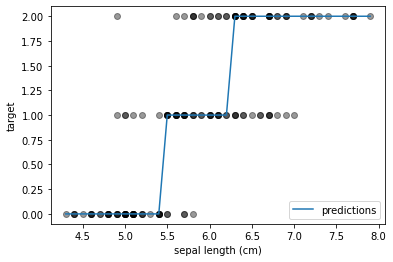

In [ ]:
import sklearn.datasets
from sklearn.linear_model import LogisticRegression

X_iris, y_iris = sklearn.datasets.load_iris(return_X_y=True, as_frame=True)

inspector = Inspector(
    LogisticRegression(max_iter=10_000).fit(X_iris.iloc[:, [0]], y_iris),
    X_iris.iloc[:, [0]],
    y_iris,
)
show_doc(inspector.plot, title_level=4, name="plot")

ax = inspector.plot()

<h4 id="plot" class="doc_header"><code>plot</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>plot</code>(**`inspector`**:[`Inspector`](/model_inspector/inspect.html#Inspector), **`plot_data`**:`bool`=*`True`*, **`heatmap_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`scatter_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`tick_formatter`**:`Optional`\[`str`\]=*`'.2f'`*, **`ax`**=*`None`*)

Plot data and predictions for classification model with two features

Parameters:
- `inspector`: [`Inspector`](/model_inspector/inspect.html#Inspector) object
- `plot_data`: Make a scatter plot of the data
- `heatmap_kwargs`: kwargs to pass to `sns.heatmap` for plotting
predictions
- `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
- `tick_formatter`: Tick label format specifier
- `ax`: Matplotlib `Axes` object. Plot will be added to this object
if provided; otherwise a new `Axes` object will be generated.

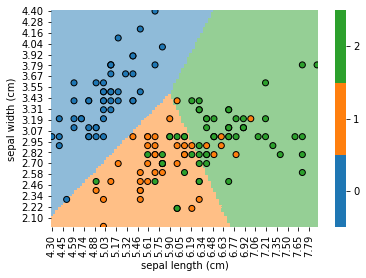

In [ ]:
import sklearn.datasets
from sklearn.linear_model import LogisticRegression

X_iris, y_iris = sklearn.datasets.load_iris(return_X_y=True, as_frame=True)

inspector = Inspector(
    LogisticRegression(max_iter=10_000).fit(X_iris.iloc[:, :2], y_iris),
    X_iris.iloc[:, :2],
    y_iris,
)
show_doc(inspector.plot, title_level=4, name="plot")

ax = inspector.plot()

<h4 id="plot3d" class="doc_header"><code>plot3d</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>plot3d</code>(**`inspector`**:[`Inspector`](/model_inspector/inspect.html#Inspector), **`plot_data`**:`bool`=*`True`*, **`surf_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`scatter_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`ax`**=*`None`*)

Plot predictions from a model with two inputs as a surface.

Best viewed with a tool such as https://github.com/matplotlib/ipympl
that supports rotating the output

Parameters:
- `inspector`: [`Inspector`](/model_inspector/inspect.html#Inspector) object
- `plot_data`: Make a scatter plot of the data
- `surf_kwargs`: kwargs to pass to `ax.plot_surface` for plotting
predictions
- `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
- `ax`: Matplotlib `Axes` object. Plot will be added to this object
if provided; otherwise a new `Axes` object will be generated.

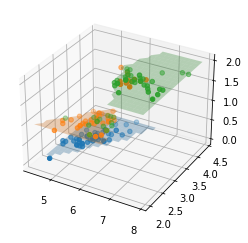

In [ ]:
import sklearn.datasets
from sklearn.linear_model import LogisticRegression

X_iris, y_iris = sklearn.datasets.load_iris(return_X_y=True, as_frame=True)

inspector = Inspector(
    LogisticRegression(max_iter=10_000).fit(X_iris.iloc[:, :2], y_iris),
    X_iris.iloc[:, :2],
    y_iris,
)
show_doc(inspector.plot3d, title_level=4, name="plot3d")

ax = inspector.plot3d()

### Regression

<h4 id="plot" class="doc_header"><code>plot</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>plot</code>(**`inspector`**:[`Inspector`](/model_inspector/inspect.html#Inspector), **`plot_data`**:`bool`=*`True`*, **`line_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`scatter_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`ax`**:`Optional`\[`Axes`\]=*`None`*)

Plot predictions from a regression or multiclass model with a
single input as a line

Parameters:
- `inspector`: [`Inspector`](/model_inspector/inspect.html#Inspector) object
- `plot_data`: Make a scatter plot of the data
- `line_kwargs`: kwargs to pass to `ax.plot` for plotting
predictions
- `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
- `ax`: Matplotlib `Axes` object. Plot will be added to this object
if provided; otherwise a new `Axes` object will be generated.

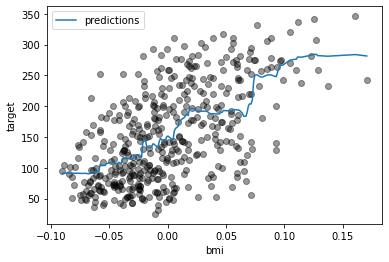

In [ ]:
import sklearn.datasets
from sklearn.ensemble import RandomForestRegressor

X_diabetes, y_diabetes = sklearn.datasets.load_diabetes(return_X_y=True, as_frame=True)

inspector = Inspector(
    RandomForestRegressor(max_depth=3).fit(X_diabetes.loc[:, ["bmi"]], y_diabetes),
    X_diabetes.loc[:, ["bmi"]],
    y_diabetes,
)
show_doc(inspector.plot, title_level=4, name="plot")

ax = inspector.plot()

<h4 id="plot" class="doc_header"><code>plot</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>plot</code>(**`inspector`**:[`Inspector`](/model_inspector/inspect.html#Inspector), **`plot_data`**:`bool`=*`True`*, **`heatmap_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`scatter_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`tick_formatter`**:`Optional`\[`str`\]=*`'.2f'`*, **`ax`**=*`None`*)

Plot predictions from a model with two inputs as a heatmap.

Parameters:
- `inspector`: [`Inspector`](/model_inspector/inspect.html#Inspector) object
- `plot_data`: Make a scatter plot of the data
- `heatmap_kwargs`: kwargs to pass to `sns.heatmap` for plotting
predictions
- `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
- `tick_formatter`: Tick label format specifier
- `ax`: Matplotlib `Axes` object. Plot will be added to this object
if provided; otherwise a new `Axes` object will be generated.

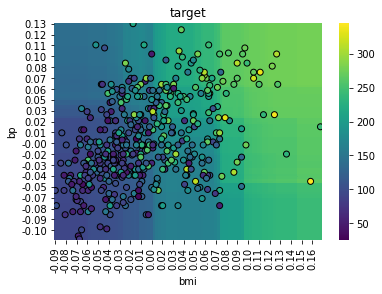

In [ ]:
import sklearn.datasets
from sklearn.ensemble import RandomForestRegressor

X_diabetes, y_diabetes = sklearn.datasets.load_diabetes(return_X_y=True, as_frame=True)

inspector = Inspector(
    RandomForestRegressor(max_depth=3).fit(
        X_diabetes.loc[:, ["bmi", "bp"]], y_diabetes
    ),
    X_diabetes.loc[:, ["bmi", "bp"]],
    y_diabetes,
)
show_doc(inspector.plot, title_level=4, name="plot")

ax = inspector.plot()

<h4 id="plot3d" class="doc_header"><code>plot3d</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>plot3d</code>(**`inspector`**:[`Inspector`](/model_inspector/inspect.html#Inspector), **`plot_data`**:`bool`=*`True`*, **`surf_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`scatter_kwargs`**:`Optional`\[`dict`\]=*`None`*, **`ax`**=*`None`*)

Plot predictions from a model with two inputs as a surface.

Best viewed with a tool such as https://github.com/matplotlib/ipympl
that supports rotating the output

Parameters:
- `inspector`: [`Inspector`](/model_inspector/inspect.html#Inspector) object
- `plot_data`: Make a scatter plot of the data
- `surf_kwargs`: kwargs to pass to `ax.plot_surface` for plotting
predictions
- `scatter_kwargs`: kwargs to pass to `ax.scatter` for plotting data
- `ax`: Matplotlib `Axes` object. Plot will be added to this object
if provided; otherwise a new `Axes` object will be generated.

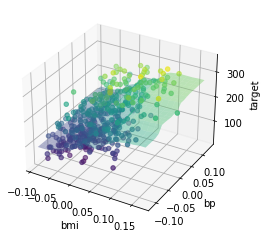

In [ ]:
import sklearn.datasets
from sklearn.ensemble import RandomForestRegressor

X_diabetes, y_diabetes = sklearn.datasets.load_diabetes(return_X_y=True, as_frame=True)

inspector = Inspector(
    RandomForestRegressor(max_depth=3).fit(
        X_diabetes.loc[:, ["bmi", "bp"]], y_diabetes
    ),
    X_diabetes.loc[:, ["bmi", "bp"]],
    y_diabetes,
)
show_doc(inspector.plot3d, title_level=4, name="plot3d")

ax = inspector.plot3d()